<img src="https://github.com/crowegian/memes/blob/master/spideyPoint.jpg?raw=true" width="40%">

<img src="https://github.com/crowegian/memes/blob/master/spideyAdmire.jpg?raw=true" width="40%">

<img src="https://github.com/crowegian/memes/blob/master/itsAlwaysSunnySpidey.jpg?raw=true" width="40%">

# Ensemble models, Confidence Intervals and the Bootstrap
In class we learned about the bootstrap. In today's lab we'll learn how to implement the bootstrap to 1) build a ensemble model (a model built by aggregating the results of a bunch of models) almost from scratch, and assess how  sure we can be that a given machine learning model is from a simple majority classifier model. After this lab you should have a deeper understanding of how to use bootstrapping to build ensebmle models, and confidence intervals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
import random
from tqdm import tqdm, tqdm_notebook

## Pulling in Data
You can read more about the dataset [here](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset)

In [2]:
breastCancer = datasets.load_breast_cancer()
X_all = breastCancer.data
randomNumGen = np.random.RandomState(seed=23)
E = randomNumGen.normal(size=X_all.shape, loc = 0.0, scale = 1)
# Add noisy data to the informative features for make the task harder
X_all += E
y_all = breastCancer.target
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.25, random_state = 23)

## Part 1: Building an ensemble model
In this section you'll implement an ensemble model. Don't worry, you'll have ample access to scikit-learn libraries, but you have to implement your own functions to generate bootstrap samples, and fit multiple models.

### Ensemble Models
An ensemble model is a model that leverages many individual models to reduce the overall model's variance. This is achieved by training multiple models (we'll be using logistic regression) and using either averaging, or majority voting to combine predictions into one single prediction. Ideally this is done with multiple datasets, but in practice gathering data can be difficult. So in order to build multiple models we use the bootstrap to generate many datasets from our single dataset. **Why might we not want to train each model on the same dataset and average results?**


### Things to do
You'll be building a model that will work like many other sklearn models. In order to do this you'll need to provide fit, predict and score functions. You will also need to implement a function to generate data using the bootstrap.

### Things to worry about
1. What happens when you call fit on a model multiple times?
2. Are you sampling with replacement during bootstrapping?
3. Inevitable heat death of the universe
4. What's for dinner?

### Deliverables
1. Fill in the ensemble model code below and using the comparison code below train it for 1,2,3,...,10 learners.
2. Answer the above bolded question
#### Your answer here

In [15]:
def generateBootStrapData(X, y):
    """
    Description: Implements the bootstrap using your own functions. Do not use any functionality
        from sklearn.
    Input:
        X (numpy matrix): A numpy matrix of shape nxm
        y (numpy array): A numpy array of length n
    Output:
        X_bs (numpy matrix): Same shape as X, with rows sampled with replacement from X
        y_bs (numpy array): Similar to X_bs but based off of y
    """
    bootStrapSampleIdxs = np.array(random.choices(np.arange(X.shape[0]), k = X.shape[0]))
    X_bs = X[bootStrapSampleIdxs]
    y_bs = y[bootStrapSampleIdxs]
    return(X_bs, y_bs)


class ensembleClassifier(BaseEstimator, ClassifierMixin):  
    """
    We're going to implement an ensemble classifier using a simple sklearn base estimator class.
    There's a lot more to implementing an estimator in sklearn, but we'll only implement three methods
    in addition to the init method.
    """

    def __init__(self, nEstimators):
        """
        Description: Called when initializing the classifier. Don't do any heavy lifting here. Just store
        information that your model will need when it's called. The init method should never learn the model,
        that should be done in the fit method.
        Note: It's s a good idea to name your objects with the same name as the arguments specified to
        init the method.
        Input:
            nEstimators (int): The number of estimators to be fit for the enesmble method.
        Output:
            None
        """
        # Store objects that you'll need for later.
        # Your code here
        self.nEstimators = nEstimators
        # End your code

    def fit(self, X, y):
        """
        Description: Fits the classifier by fitting all ensemble models on bootstrapped data.
        You'll be making use of the generateBootStrapData() function. 
        All heavy lifting is done here. You'll need to store all estimators a list called self.estimators_
        self.estimators_ will contain nEstimators LogisticRegression() objects
        Input:
            X (numpy matrix): A numpy matrix of shape nxm
            y (numpy array): A numpy array of length n
        Output:
            self (ensembleClassifier): Always return self when in the fit function to work with sklearn.
        """
        # Fit nEstimators logistic regressions
        # Your code here
        self.estimators_ = [LogisticRegression(solver = "liblinear") for i in range(self.nEstimators)]
#         self.estimators_ = [LogisticRegression(solver = "liblinear")]*self.nEstimators # this is incorrect
# because the same model is fit over and over.

        if self.nEstimators > 1:
            for estimator in self.estimators_:
                X_bootStrap, y_bootStrap = generateBootStrapData(X, y)
                estimator.fit(X_bootStrap, y_bootStrap)
        else:
            self.estimators_[0].fit(X, y)
        # End your code
        return(self)


    def predict(self, X):
        """
        Description: For each of your classification models make a class prediction for each 
            observation. Take an average of all predictions and use a threshold of 0.5 to make a class prediction
            to create an overall ensemble prediction.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
        Output:
            predictions (np.array): A numpy array of 1s or 0s indicating a prediction for all
                n inputs in X.
        """
        try:
            getattr(self, "estimators_")
        except AttributeError:
            raise RuntimeError("You're gonna want to train the your estimators first my (th)dude(et)")
            # fun fact. "thude" is a gender neutral term for dude.
        # Make some predictions
        # Your code here
        predictions = [estimator.predict(X) for estimator in self.estimators_]
        predictions = np.array(predictions)
        predictions = np.mean(predictions, axis = 0)
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
        # End your code
        return(predictions)

    def score(self, X, y):
        """
        Description: Using your prediction function predict the classes for X, and assess performance 
            against y using accuracy.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
            y (numpy array): A numpy array of classes with the same number of observations as X
        Output:
            accuracy (float): a float between 0 and 1 indicating how many elements you predicted the
                correct class for
        """
        predictions = self.predict(X)
        # Your code here
        accuracy = np.mean(predictions == y)
        # end your code
        return(accuracy) 

In [14]:
clf_ens = ensembleClassifier(nEstimators = 2)
clf_ens.fit(X = X_train, y = y_train)
score = clf_ens.score(X_test, y_test)
print(score)

0.9370629370629371


In [22]:
def testClassifier(X_train, y_train, X_test, y_test, nEstimators):
    """
    Description: Runs your classifier a bunch of times to get an estimate of performance. Expects that
        all methods have been completed in the ensembleClassifier class. 
        NOTE: You should not change this function at all. Your model should be able to be run using the
        code presented here.
    Input:
        X_train, y_train, X_test, y_test (numpy matrices and arrays): X_() is a matrix of observations
            y_() is a numpy array of classes of the same shape as its X_() conterpart
        nEstimators (int): Creates a new ensemble classifier each time with nEstimators classifiers.
            NOTE: You might have to do something similar to this retrain multiple estimators. Notice how 
            I'm initializing a new object at each iteration. Think about (google) why I might be doing this.
    Output
        None: Just here to print.
    """
    allScores = []
    nRuns = 50
    for i in range(nRuns):
        clf_ens = ensembleClassifier(nEstimators = nEstimators)
        clf_ens.fit(X = X_train, y = y_train)
        score = clf_ens.score(X_test, y_test)
        allScores.append(score)
    mean = np.mean(allScores)
    std = np.std(allScores)
    print("Average score for {} runs and {} estimators: {} (std:{})".format(nRuns, nEstimators, mean, std))

In [24]:
# Test the performance of your model by getting the measure of multiple runs.
for i in np.arange(1, 11, 1):
    testClassifier(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, nEstimators = i)

Average score for 50 runs and 1 estimators: 0.9370629370629371 (std:0.0)
Average score for 50 runs and 2 estimators: 0.9302097902097901 (std:0.011742422796392933)
Average score for 50 runs and 3 estimators: 0.9299300699300699 (std:0.009937946250903796)
Average score for 50 runs and 4 estimators: 0.9376223776223778 (std:0.009469264827866138)
Average score for 50 runs and 5 estimators: 0.9317482517482518 (std:0.010793723849832017)
Average score for 50 runs and 6 estimators: 0.9365034965034965 (std:0.009365409254703876)
Average score for 50 runs and 7 estimators: 0.9353846153846155 (std:0.010883958857814666)
Average score for 50 runs and 8 estimators: 0.936783216783217 (std:0.008617019189230395)
Average score for 50 runs and 9 estimators: 0.9345454545454547 (std:0.009145612712879333)
Average score for 50 runs and 10 estimators: 0.9387412587412588 (std:0.008796746961407762)


## Part 2: Confidence Intervals
No we want to test if a classifier of our choice is better than a simple majority classifier, and assess how sure we are of this claim. We're going to use this by using even more bootstrapping to create new trainig datasets, train our classifier, and assess performance on the same test set.  **You can use any classification model you want as long as it's accessible from sklearn, otherwise you're gonna have a bad time. You can even use your ensemble model.**

In order to do this we're going to use our bootstrap model above to assess performance on even more bootstrap data. The general algorthm is as follows.

Given $X_{train}$, $y_{train}$, $X_{test}$ and $y_{test}$ as inputs do.
1. Sample $X^{bs}_{train}$ from $X_{train}$ and $y^{bs}_{train}$, from $y_{train}$ using the bootstrap algorithm.
2. Train our model using $X^{bs}_{train}$ and $y^{bs}_{train}$
3. Evaluate the ensemble model on $X_{test}$ and $y_{test}$
4. Store our test statistic (accuracy)


Next evaluate whether or not a majority classifier trained on $X_{train}$ and evaluated on $X_{test}$ has performance within the 95% confidence intervals of the ensemble model. Note: A majority classifier simple takes the majority class in the training set and assigns the class to all values it's evaluated on


### Deliverables
Plot a histogram of the ensemble model's **bootstrap performances** with vertical lines for the **lower and upper confidence intervals** as well as for the **majority classifer performance**. You can get all but the majority classifier values from the function `calculateConfidenceIntervals`

In [12]:
def calculateConfidenceIntervals(X_train, y_train, X_test, y_test, R, confInterval = 0.95):
    """
    Description: Calculates confidence intervals of your model by obtaining R bootstrap samples of the 
        orginal training data, fitting a classifier on this data, and assessing performance on the original
        testing data. Then the (1-confInterval)/2% of scores are trimmed from either side of the sorted
        scores to assess which scores are within the confidence interval. Please refer to your reading
        on confidence intervals in Practical Statistics for Data Scientists. 
    Input:
        X_train, y_train, X_test, y_test (numpy matrices and arrays): X_() is a matrix of observations
            y_() is a numpy array of classes of the same shape as its X_() conterpart
        R (int): The number of times to generate bootstrap samples and train a model  
        confInterval (float): A float between 0.0 and 1.0 indicating the confidence interval.
    Output:
        allScores (np.array): An array of scores generated using bootstrapped data.
        lowerConfBound (float): An elemnt from allScores which indicates the cutoof for the upper bound
            of the confidence interval
        upperConfBound (float): An elemnt from allScores which indicates the cutoof for the lower bound
            of the confidence interval
    """
    allScores = [0.0]*R
    # Your code here
    for r in tqdm_notebook(range(R)):
        clf = LogisticRegression(solver = "liblinear")
        X_bs_train, y_bs_train = generateBootStrapData(X = X_train, y = y_train)
        clf.fit(X = X_bs_train, y = y_bs_train)
        score = clf.score(X_test, y_test)
        allScores[r] = score
    allScores = np.sort(allScores)
    nTrim = int(np.floor(((1 - confInterval)/2)*R))
    print("Trimming off {} elements from either side of scores".format(nTrim))
    lowerConfBound = allScores[(nTrim - 1)]
    upperConfBound = allScores[-nTrim]
    # End your code
    return(allScores, lowerConfBound, upperConfBound)

In [13]:
allScores, lowerConfBound, upperConfBound = calculateConfidenceIntervals(X_train = X_train, y_train = y_train,
                                                                         X_test = X_test, y_test = y_test,
                                                                         R = 1000,
                                                                         confInterval = 0.95)


Trimming off 25 elements from either side of scores


In [14]:
# Implement code to "train" a majority classifier and get its accuracy on the test set.
# Your code here
if np.mean(y_train) >= 0.5:
    majorityClass = 1
else:
    majorityClass = 0
majorityClassiferPerf = np.mean(y_test == majorityClass)
# End your code
print("majority classifier performance = {}".format(majorityClassiferPerf))

majority classifier performance = 0.6643356643356644


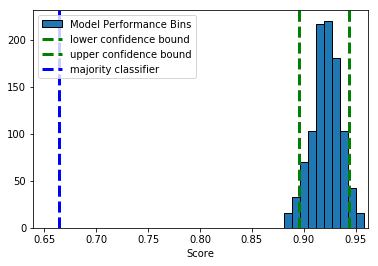

In [25]:
# Plot what is described in the deliverables
# Your code here
plt.hist(allScores, bins = 10, label='Model Performance Bins',
         edgecolor='black')
ylim = plt.ylim()
xlim = plt.xlim()
if xlim[0] > majorityClassiferPerf:
    xlim = (majorityClassiferPerf - 0.025, xlim[1])
plt.vlines(lowerConfBound, ymin = ylim[0], ymax = ylim[1], linestyle='--',
         color='g', linewidth=3,
         label = "lower confidence bound")
plt.vlines(upperConfBound, ymin = ylim[0], ymax = ylim[1], linestyle='--',
         color='g', linewidth=3,
         label = "upper confidence bound")
plt.vlines(majorityClassiferPerf, ymin = ylim[0], ymax = ylim[1], linestyle='--',
         color='b', linewidth=3,
         label = "majority classifier")
plt.ylim(ylim)
plt.xlim(xlim)
plt.legend()
plt.xlabel('Score')
plt.show()
# End your code